In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})



In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from utils import (
    get_prepared_train_test,
    get_anomaly_detection_report,
    get_detection_score,
    get_best_score_threshold,
)

In [7]:
# Custom Dataset for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data  # TODO: preprocess

        # self.preprocess()
    
    def preprocess(self):
        raise NotImplementedError()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample, torch.tensor(0)

def get_dataloader(dataset, batch_size=64, shuffle=True):
    dataset = TabularDataset(dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [8]:
class BTCAddressAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [15]:
import torch
from torch import nn, optim
from tqdm import tqdm

def plot_losses(train_loss, val_loss):
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.plot(range(1, len(train_loss) + 1), train_loss, label="train")
    axs.plot(range(1, len(val_loss) + 1), val_loss, label="val")
    axs.set_ylabel('loss')

    axs.set_xlabel('epoch')

    plt.show()

def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-3, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # You can also try nn.SmoothL1Loss()

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch[0]
            batch = batch.to(device)
            optimizer.zero_grad()

            recon = model(batch)
            loss = criterion(recon, batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch[0]
                val_batch = val_batch.to(device)
                val_recon = model(val_batch)
                val_loss = criterion(val_recon, val_batch)
                total_val_loss += val_loss.item() * val_batch.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        plot_losses(train_losses, val_losses)

    print("✅ Training complete.")

def compute_reconstruction_errors(model, X_np, device='cuda'):
    model.eval()
    X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon = model(X_tensor)
        errors = torch.mean((X_tensor - recon) ** 2, axis=1)

    return errors.cpu().numpy()



**Prepare dataset**

In [13]:
wallets_feats = pd.read_csv("../dataset/custom/features_fixed/wallets_features_agg.csv")
wallets_feats.head()

,addrId,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,incoming_tx_cnt,incoming_tx_input_address_cnt_mean,incoming_tx_output_address_cnt_mean,btc_received_gini,input_address_cnt,...,outcoming_tx_fees_total,outcoming_tx_ts_cnt,outcoming_tx_ts_gini,incoming_tx_ts_cnt,incoming_tx_ts_gini,Time step,class,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,6.999303,6.999303,6.999303,6.999303,1.0,1.0,2.0,0.0,1.0,...,0.0010,1.0,0.0,1.0,0.0,1,3,391200.0,391200.0,0.0
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0001,1.0,0.0,0.0,0.0,1,3,391200.0,391200.0,0.0
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,0.390310,0.390310,0.390310,0.390310,1.0,4.0,2.0,0.0,4.0,...,0.0001,1.0,0.0,1.0,0.0,1,3,391200.0,399271.0,8071.0
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0001,1.0,0.0,0.0,0.0,1,3,391200.0,391200.0,0.0
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,3.200299,3.200299,3.200299,3.200299,1.0,1.0,2.0,0.0,1.0,...,0.0001,1.0,0.0,1.0,0.0,1,3,391200.0,391200.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def transform_dataset(df_raw, scaler, tp="licit"):
    if tp == "all":
        df = df_raw
    if tp == "illicit":
        df = df_raw[df_raw["class"] == 1]
    if tp == "licit":
        df = df_raw[df_raw["class"] == 2]
    if tp == "unknown":
        df = df_raw[df_raw["class"] == 3]
    if tp == "no_illicit":
        df = df_raw[df_raw["class"] != 1]
    df = df.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ])
    scaler = StandardScaler()
    df_transformed = scaler.fit_transform(df)

    return df_transformed

In [124]:
scaler = StandardScaler()
scaler.fit(wallets_feats.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

dataset_transformed = transform_dataset(wallets_feats, scaler, tp="licit")
dataset_fraud_transformed = transform_dataset(wallets_feats, scaler, tp="illicit")
dataset_unk_transformed = transform_dataset(wallets_feats, scaler, tp="unknown")

dataset_train, dataset_val = train_test_split(
    dataset_transformed,
    test_size=0.15
)
train_loader = get_dataloader(dataset_train)
val_loader = get_dataloader(dataset_val)

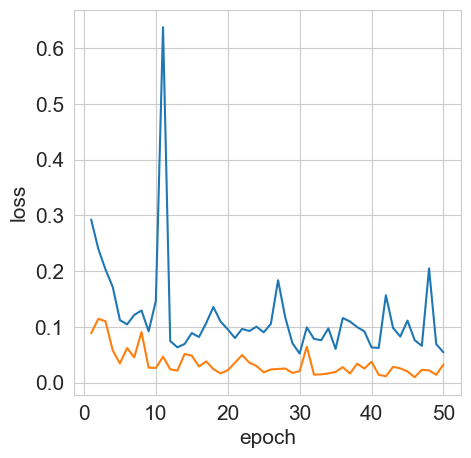

✅ Training complete.


In [47]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu"
)

In [19]:
def get_licit_illicit_recon_errors(
        model,
        licit_dataset,
        illicit_dataset,
        unk_dataset=None,
        cnt=20,
        plot=False
):
    licit_idxs = np.random.choice(licit_dataset.shape[0], cnt if cnt is not None else licit_dataset.shape[0], replace=False)
    illicit_idxs = np.random.choice(illicit_dataset.shape[0], cnt if cnt is not None else illicit_dataset.shape[0], replace=False)
    licit_errs = compute_reconstruction_errors(
        model,
        licit_dataset[licit_idxs],
        device="cpu"
    )
    illicit_errs = compute_reconstruction_errors(
        model,
        illicit_dataset[illicit_idxs],
        device="cpu"
    )

    if unk_dataset is not None:
        unk_idxs = np.random.choice(unk_dataset.shape[0], cnt if cnt is not None else unk_dataset.shape[0], replace=False)
        unk_errs = compute_reconstruction_errors(
            model,
            unk_dataset[unk_idxs],
            device="cpu"
        )

    if plot:
        # sns.histplot(licit_errs[licit_errs<np.quantile(licit_errs, 0.95)], label="Licit", bins=30)
        # sns.histplot(illicit_errs[illicit_errs<np.quantile(illicit_errs, 0.95)], label="Illicit", bins=30)

        sns.histplot(licit_errs[licit_errs<0.8], label="Licit", bins=30)
        sns.histplot(illicit_errs[illicit_errs<0.8], label="Illicit", bins=30)
        
        if unk_dataset is not None:
            sns.histplot(unk_errs[unk_errs<0.8], label="Unknown", bins=30, alpha=0.5)
        plt.legend()
        
    return licit_errs, illicit_errs

(array([0.00678498, 0.00122546, 0.00220972, ..., 0.00610104, 0.00152789,
        0.00242372], dtype=float32),
 array([0.03785777, 0.03651204, 1.1389788 , ..., 0.09837189, 0.01988318,
        0.02599768], dtype=float32))

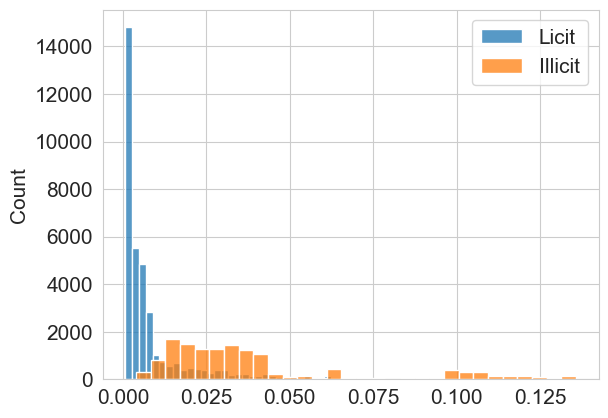

In [126]:
get_licit_illicit_recon_errors(
    autoencoder,
    dataset_val,
    dataset_fraud_transformed,
    cnt=None,
    plot=True
)

(array([0.03318103, 0.00821541, 0.00301206, ..., 0.00141369, 0.00229823,
        0.00821541], dtype=float32),
 array([0.03661707, 0.0270613 , 0.0629928 , ..., 1.4317366 , 0.02871591,
        0.01429698], dtype=float32))

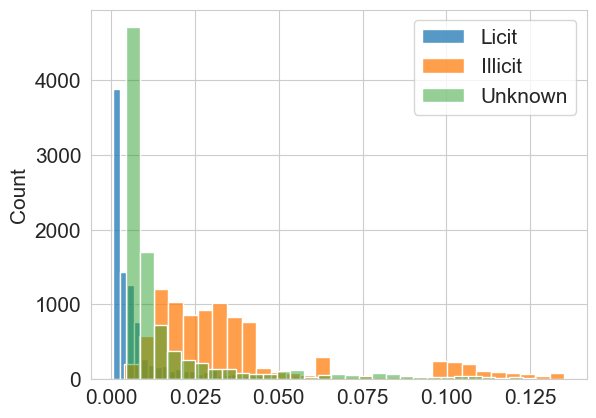

In [134]:
get_licit_illicit_recon_errors(
    autoencoder,
    dataset_val,
    dataset_fraud_transformed,
    dataset_unk_transformed,
    cnt=10000,
    plot=True
)

### **Train on separate splits (licit only)**

In [174]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__test.csv")

scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="licit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

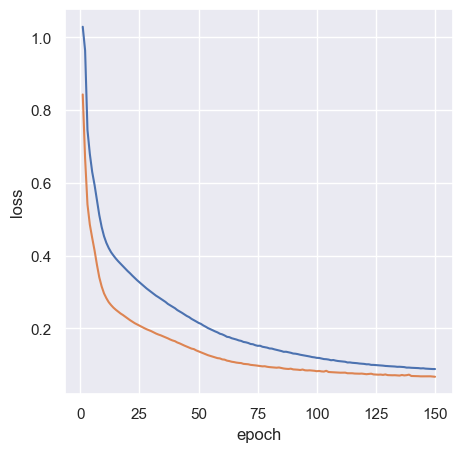

✅ Training complete.


In [192]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=150
)

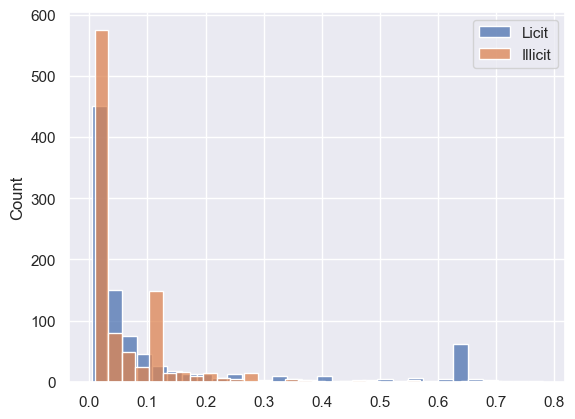

In [193]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

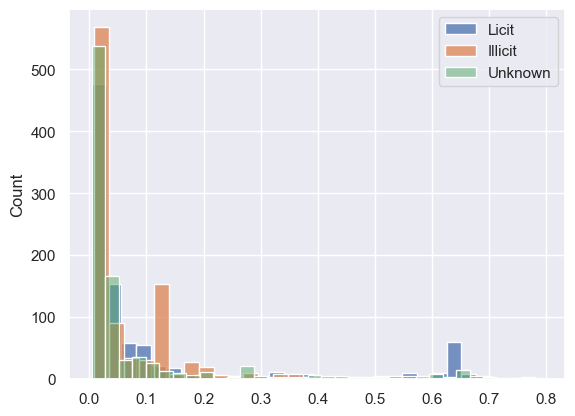

In [194]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    test_data[test_labels == 3],
    cnt=1000,
    plot=True,
)

In [195]:
test_data[test_labels == 1].shape

(2721, 33)

In [173]:
test_data.shape

(646229, 33)

In [196]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")


	real 1	real 0
pred 1	1146	61230	
pred 0	1575	121076	
[0.014705961832597404, 0.014922343466262885, 0.017212069698257542, 0.01724416713431047, 0.01644404031607392, 0.01673313681290099, 0.017865472525422147, 0.018963106020245073, 0.016219588271990017, 0.01645023283988945, 0.01633187943747922, 0.017014598690867043, 0.017105720744218397, 0.016932449381831215, 0.01692573402417962, 0.017357624444125662, 0.008476676746145839, 0.00823585882828487, 0.007684346701164295, 0.007639641544846546, 0.007796158965582811, 0.00777000777000777, 0.007758061331001213, 0.006743242470998343, 0.006759294029290274, 0.0065369056692267105, 0.006221435942798172, 0.00623545557610836, 0.0056753688989784334, 0.005616417219564882, 0.005377520712834141, 0.0052786294528558335, 0.005154971325472002, 0.0051343710395476555, 0.00508146739664951, 0.005037866315442871, 0.005075805327936834, 0.004959680296867195, 0.004435789245915828, 0.004416703168345744]


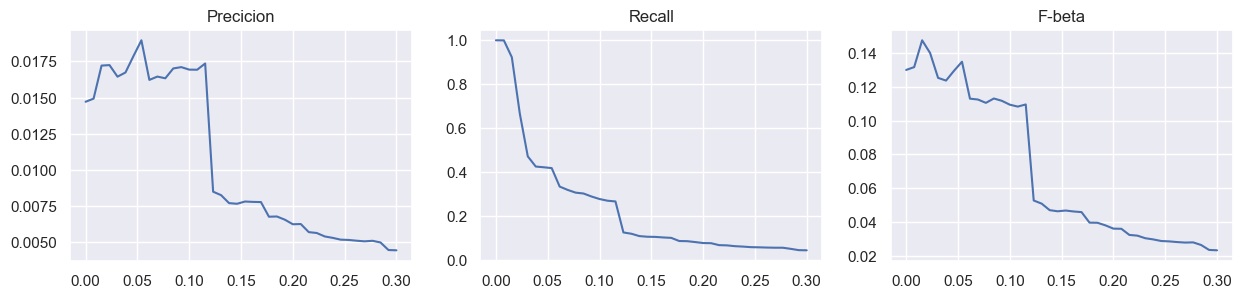

In [199]:
get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)

	real 1	real 0
pred 1	1146	24815	
pred 0	1575	34581	
[0.043804433568910284, 0.04501969611705121, 0.05133814479360471, 0.047817486482922326, 0.03946276546700679, 0.04029928658430486, 0.04288753685939308, 0.04639511201629328, 0.04036192672757917, 0.04125913968284114, 0.04129370456456159, 0.04513584574934268, 0.04419858474671459, 0.04409963250306247, 0.04436798261499457, 0.04570349386213409, 0.022721233058729737, 0.02209270805096232, 0.02055221091965954, 0.020287820287820287, 0.020387866732968673, 0.02015403440581588, 0.0201894134057705, 0.01767260745843942, 0.01761782864026502, 0.017109099278809266, 0.016293436293436294, 0.01634600344126388, 0.014743385400063756, 0.01455534229046705, 0.014083353803324327, 0.013924789460518635, 0.013596193065941536, 0.013536668951336532, 0.013443191673894189, 0.013321723987810187, 0.013384655760650862, 0.012271563520791031, 0.01092265340555901, 0.010869565217391304]


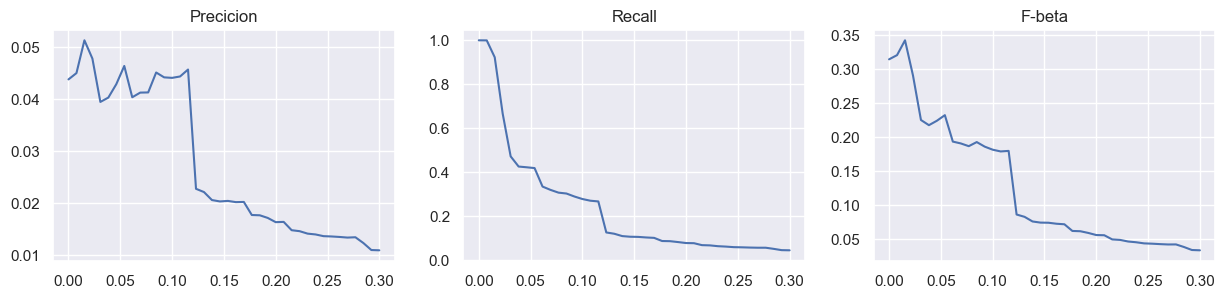

In [200]:
get_best_score_threshold(
    licit_scores,
    illicit_scores,
    np.array([]),
    plot=True,
    thr_interval=(0,0.3)
)

### **Train on separate splits (licit + unknown)**

In [203]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__test.csv")

scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

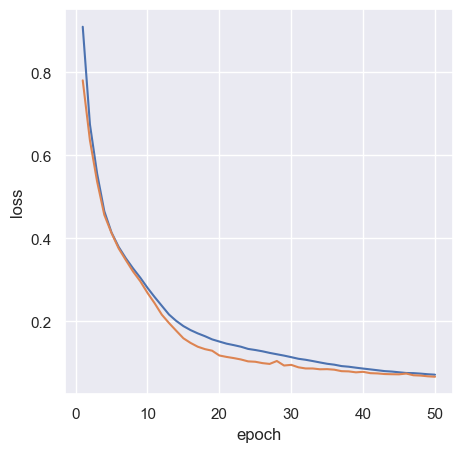

Training: 100%|██████████| 50/50 [05:51<00:00,  7.03s/it]

✅ Training complete.


In [207]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

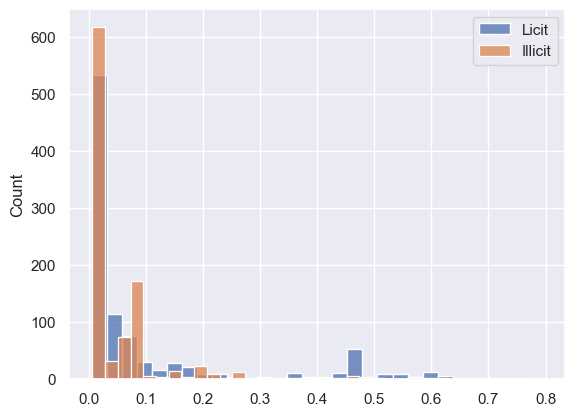

In [211]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	969	51167	
pred 0	1752	131139	
[0.014705961832597404, 0.015067587463678336, 0.014319847340485239, 0.014136255260380702, 0.015854018682872995, 0.016940990316977107, 0.018110221594813975, 0.018652910717087714, 0.016879068682542037, 0.017314675405189973, 0.017046896265368733, 0.007526439340771037, 0.007474772642332129, 0.0074034362155676395, 0.007516820857863751, 0.0075495944100875435, 0.007930600091617042, 0.008135715792328321, 0.008190872141726908, 0.00753021578181358, 0.007362160424369072, 0.007312434417628542, 0.007399013464871351, 0.00739190603166031, 0.007636016544702514, 0.007671625739379817, 0.006088890509352098, 0.0058024237972824095, 0.005007046954973666, 0.0046920160654630085, 0.004652049571020019, 0.004568706314186419, 0.0046128762874299125, 0.004594180704441042, 0.0040219378427787935, 0.003457216940363008, 0.0034037607405255073, 0.0034453781512605044, 0.003435405886843668, 0.003375491368996753]


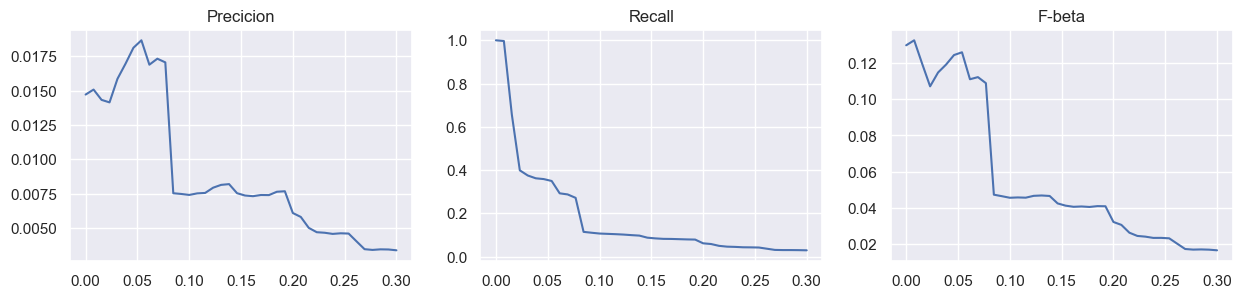

In [213]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)


### **On new dataset (wallers feats only)** 

In [5]:
pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv").columns

Index(['addrId', 'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'incoming_tx_cnt',
       'incoming_tx_input_address_cnt_mean',
       'incoming_tx_output_address_cnt_mean', 'btc_received_gini',
       'input_address_cnt', 'incoming_tx_fees_mean', 'incoming_tx_fees_min',
       'incoming_tx_fees_max', 'incoming_tx_whole_fee_4_cnt', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'outcoming_tx_cnt',
       'outcoming_tx_output_address_cnt_mean',
       'outcoming_tx_input_address_cnt_mean', 'btc_sent_gini',
       'output_address_cnt', 'outcoming_tx_fees_mean', 'outcoming_tx_fees_min',
       'outcoming_tx_fees_max', 'outcoming_tx_whole_fee_4_cnt',
       'outcoming_tx_fees_total', 'outcoming_tx_ts_cnt',
       'outcoming_tx_ts_gini', 'incoming_tx_ts_cnt', 'incoming_tx_ts_gini',
       'Time step', 'class', 'first_block_appeared_in',
       'last_block_appeared_in', 'lifetime_in_blocks', 'userId',
       'user_addr_cnt

In [110]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

train_data_full = train_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])
test_data_full = test_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])


scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

In [111]:
train_data.shape

(461184, 35)

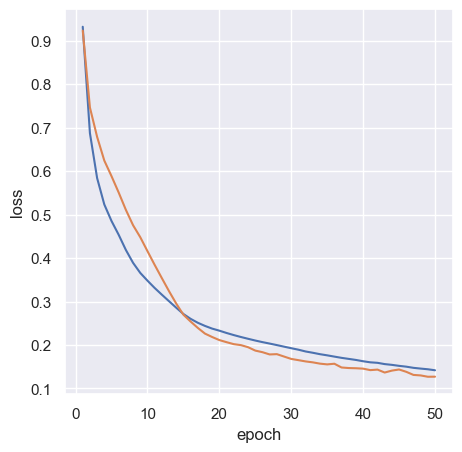

Training: 100%|██████████| 50/50 [12:02<00:00, 14.44s/it]

✅ Training complete.


In [112]:
autoencoder = BTCAddressAutoencoder(input_dim=35)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

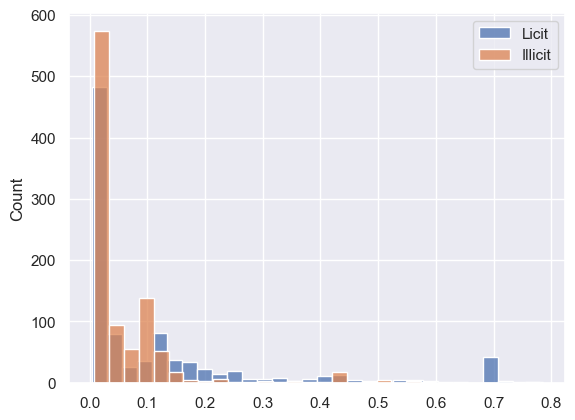

In [113]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	1385	88861	
pred 0	3120	187668	
Precicion 0.01534694058462425, Recall 0.3074361820199778, Acc=0.67270508194738
[0.01603008888604226, 0.01639344262295082, 0.020645419923832432, 0.020633116776477854, 0.01646711497457766, 0.01674127515320092, 0.015108915089556503, 0.015501915857856962, 0.01560665214729468, 0.015768013761175648, 0.015216128218901764, 0.015348583382600391, 0.01153897923473196, 0.008741549196774317, 0.008311633656855782, 0.005465229361568069, 0.005601562165937371, 0.005721248866895516, 0.005662216309039434, 0.005704660660088033, 0.005293011905154503, 0.005330653814057258, 0.005376438241011541, 0.0054532692619189025, 0.00547612922194862, 0.005534358354425598, 0.0055603991087862055, 0.005672385168788046, 0.0057742569443037465, 0.00552840814974325, 0.005547937981225609, 0.0055479098572165835, 0.0055498503288395565, 0.00582397614499371, 0.005934861278648975, 0.005996636033444653, 0.006048785305155046, 0.006311471098721927, 0.0064502082029230055, 0.006430691

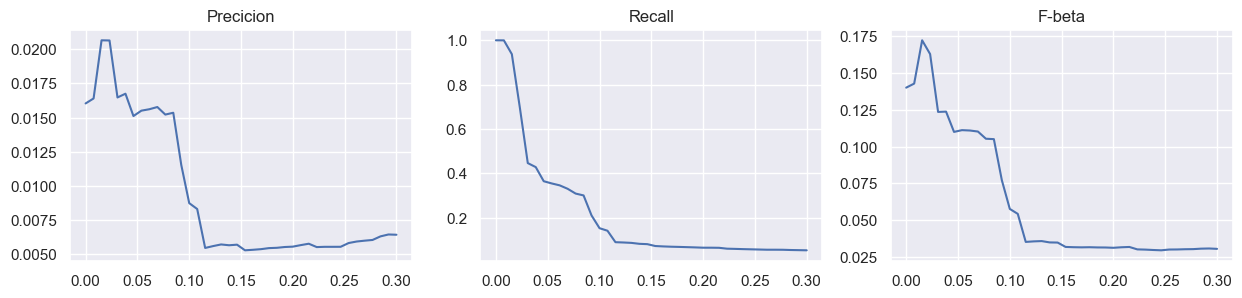

In [114]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)


In [22]:
(2016+179593) / (2016+179593+2489+96936)

0.6462171836859597

### **On new dataset (full - wallets + users)** 

In [62]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

train_data_full = train_data_full.drop(columns=[
    'userId',
])
test_data_full = test_data_full.drop(columns=[
    'userId',
])


scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

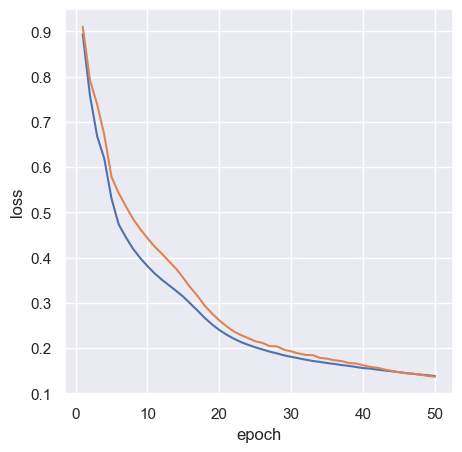

Training: 100%|██████████| 50/50 [05:15<00:00,  6.31s/it]

✅ Training complete.


In [65]:
autoencoder = BTCAddressAutoencoder(input_dim=53)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

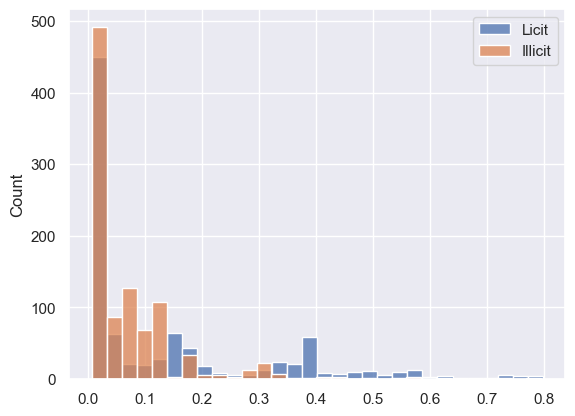

In [66]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	2103	103047	
pred 0	2402	173482	
Precicion 0.02, Recall 0.46681465038845726, Acc=0.6247820548403396
[0.01603008888604226, 0.02045239062711635, 0.017793322115451475, 0.01863921593996636, 0.01888588273655824, 0.01904157410345922, 0.018330984497684718, 0.019190219590637048, 0.014574280549286445, 0.011732107062846362, 0.011161358606754546, 0.011015911872705019, 0.006410822680178191, 0.006486869004560466, 0.006618693445748195, 0.006921927425494121, 0.006543715245682762, 0.005891676884887998, 0.005720420458915524, 0.005581041021479555, 0.005693223506610369, 0.005716189440830426, 0.0056975505857295, 0.0056296349759116585, 0.005635646372279892, 0.005604087687489699, 0.005605816728645168, 0.005139226312838722, 0.005013432214612736, 0.00487993803253292, 0.003803131991051454, 0.003808009373561535, 0.0038408957750146475, 0.0037936439426637285, 0.0038681506442962577, 0.0039687430670249215, 0.003847024213622992, 0.003866776654980408, 0.0038801924150211283, 0.004219285651498725]

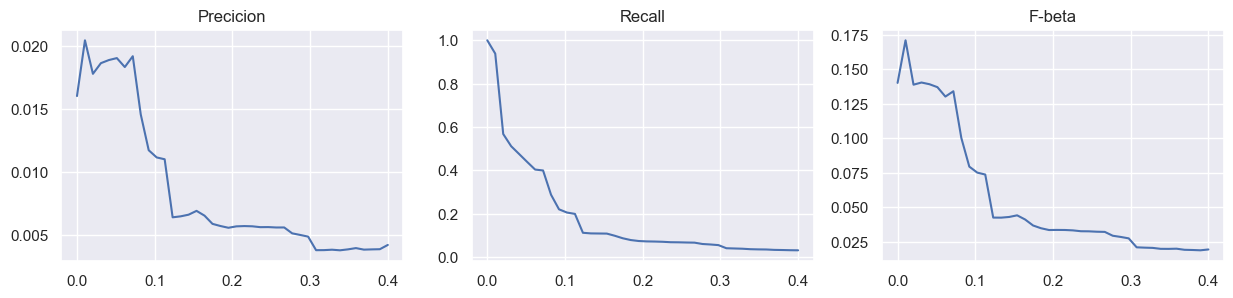

In [80]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.4)
)


In [123]:
test_data_full.columns

Index(['addrId', 'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'incoming_tx_cnt',
       'incoming_tx_input_address_cnt_mean',
       'incoming_tx_output_address_cnt_mean', 'btc_received_gini',
       'input_address_cnt', 'incoming_tx_fees_mean', 'incoming_tx_fees_min',
       'incoming_tx_fees_max', 'incoming_tx_whole_fee_4_cnt', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'outcoming_tx_cnt',
       'outcoming_tx_output_address_cnt_mean',
       'outcoming_tx_input_address_cnt_mean', 'btc_sent_gini',
       'output_address_cnt', 'outcoming_tx_fees_mean', 'outcoming_tx_fees_min',
       'outcoming_tx_fees_max', 'outcoming_tx_whole_fee_4_cnt',
       'outcoming_tx_fees_total', 'outcoming_tx_ts_cnt',
       'outcoming_tx_ts_gini', 'incoming_tx_ts_cnt', 'incoming_tx_ts_gini',
       'Time step', 'class', 'first_block_appeared_in',
       'last_block_appeared_in', 'lifetime_in_blocks', 'exchange_flg',
       'transac

In [125]:
def get_badly_reconstructed_data_examples(
        model,
        data_raw,
        data_transformed,
        labels,
        cls,
        cnt=20,
        thr=0.2,
):
    class_full = data_raw[labels == cls].reset_index()
    class_full_transformed = data_transformed[labels == cls]

    errs = compute_reconstruction_errors(model, class_full_transformed, device="cpu")
    class_full["recon_err"] = errs
    idxs = []
    for i in range(errs.shape[0]):
        if errs[i] > thr:
            idxs.append(i)
            if len(idxs) > cnt:
                break

    return class_full.iloc[idxs][[
        "addrId",
        "btc_received_total",
        "incoming_tx_cnt",
        "input_address_cnt",
        "btc_sent_total",
        "outcoming_tx_cnt",
        "output_address_cnt",
        "recon_err",
    ]]


get_badly_reconstructed_data_examples(
    autoencoder,
    test_data_full,
    test_data,
    test_labels,
    cls=1,
    thr=0.05
)

,addrId,btc_received_total,incoming_tx_cnt,input_address_cnt,btc_sent_total,outcoming_tx_cnt,output_address_cnt,recon_err
0,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,4.972163,23.0,23.0,4.571836,26.0,52.0,91.259842
1,1DhSUSvEwsvHPALZQ8N6C4Ust68Le9NGX8,0.000000,0.0,0.0,0.010054,1.0,2.0,1.896219
2,1MBaoDkGC4pdfVaQbwSzMscdrsU6hUioc8,1.475440,1.0,3.0,1.053946,1.0,1.0,0.111626
3,15MWpwCShpqz5V9z4mjcDCaY5FJKdHrhbc,1.880452,1.0,2.0,1.053946,1.0,1.0,0.111916
4,1BQz3DUZL3A2zz2TRvNKW62gJwtkedAn5R,0.650602,1.0,4.0,1.053946,1.0,1.0,0.111387
5,17Myg4Zt4oqxy5fapiEj4G2g8f2iCuBER6,0.001909,1.0,16.0,1.053946,1.0,1.0,0.129924
6,189UWpf1porctvELBS1fWYuELhiNBE2W1e,3.755002,1.0,1.0,1.053946,1.0,1.0,0.112984
7,1AmTKyX61EGMioXpK9vrxdFKbupbQWJxHP,1.880452,1.0,2.0,1.053946,1.0,1.0,0.111916
8,1FPfyCbb9iVQk5DzXdxw1bH4e3bdf5JbU1,0.650602,1.0,4.0,1.053946,1.0,1.0,0.111387
9,19Xz73LuJE4JST6H6v5LVSzYsMYp6Dpf8E,0.002628,1.0,22.0,1.053946,1.0,1.0,0.155592


In [126]:
get_badly_reconstructed_data_examples(
    autoencoder,
    test_data_full,
    test_data,
    test_labels,
    cls=2,
    thr=0.05
)

,addrId,btc_received_total,incoming_tx_cnt,input_address_cnt,btc_sent_total,outcoming_tx_cnt,output_address_cnt,recon_err
1,3CswTd6V8V2uv24P9yWHpPnFiLfN4CABgW,15.734749,7.0,17.0,1472.667095,3.0,7.0,11.814948
5,1AyVSLR8yt8BCZvx8syjYJESNFfWgNuUzM,0.000000,0.0,0.0,96.747372,2.0,4.0,1.829612
7,153wcbzkZo3VmXad42b2gP6DfANEX7ur54,0.000000,0.0,0.0,96.747372,2.0,4.0,1.829612
9,1FXNGLdU1c1uMghi9r7xNpYA1jygC2juPD,0.000000,0.0,0.0,5.162142,2.0,4.0,0.858887
10,16jzkB5PTsN8pp7bMApwevPYmd8xzT5NrW,0.000000,0.0,0.0,110.391948,2.0,4.0,1.436604
12,1N1F8hrhAtV46kPjvTLF66yA9CM7THVLRg,0.000000,0.0,0.0,96.747372,2.0,4.0,1.829612
14,18a6WnV2qMM9hExA2RDRrUzaH3EqpLiWhG,0.000000,0.0,0.0,2.431722,2.0,4.0,1.452386
17,1FoXbDsvXgwVoFwkszaZjkuRRDADoWTygX,0.028254,4.0,4.0,750.234006,2.0,1.0,4.366258
20,1EZ9PzwpYYHGPDFTLzZKs49UxTjtMZRw3g,0.000000,0.0,0.0,1.207649,4.0,8.0,1.675439
21,13Lt2uBNPwzuP1iyUHsddS2hGpk21pzZkF,0.000000,0.0,0.0,0.005000,1.0,1.0,0.440104


### Wallets + users (train on licit only)

In [81]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

train_data_full = train_data_full.drop(columns=[
    'userId',
])
test_data_full = test_data_full.drop(columns=[
    'userId',
])


scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="licit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

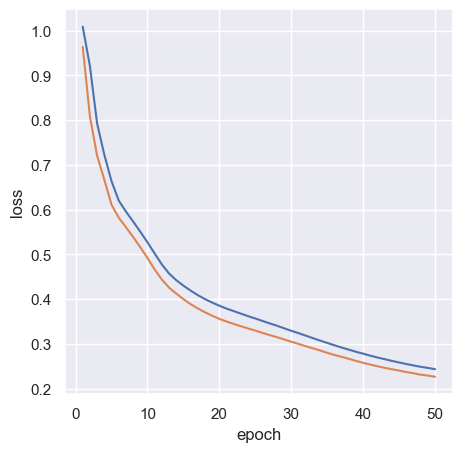

Training: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]

✅ Training complete.


In [82]:
autoencoder = BTCAddressAutoencoder(input_dim=53)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

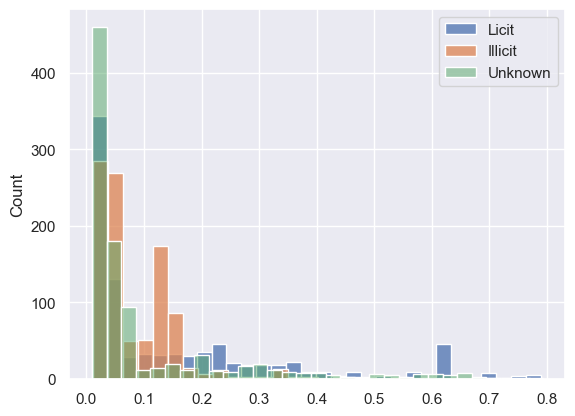

In [85]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    test_data[test_labels == 3],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	1926	101456	
pred 0	2579	175073	
Precicion 0.018629935578727438, Recall 0.42752497225305214, Acc=0.629813474526214
[0.01603008888604226, 0.016074531590647156, 0.018857549347775806, 0.019640250117070216, 0.021244090261576892, 0.018748582910486852, 0.017713651874243234, 0.017926542230007114, 0.0186419149975574, 0.019262921440513676, 0.019396032867535457, 0.018696871766977038, 0.014284628002216018, 0.009826338155414524, 0.009610300034486723, 0.0065416484954208464, 0.006076484987145897, 0.005403991981173189, 0.004972663038652307, 0.005062494262069327, 0.005091787964371063, 0.005239308977626735, 0.0053648543088328495, 0.0051226208186990994, 0.005042282462657077, 0.005019003995711919, 0.00495764990588868, 0.004988599934856771, 0.005076690429898466, 0.005200830636259892, 0.005464811453922162, 0.005511137089535103, 0.005555075220473803, 0.004433285833842257, 0.004479492324203257, 0.004612078332890638, 0.004628707943460084, 0.004595658245524946, 0.004579755399427531, 0.004

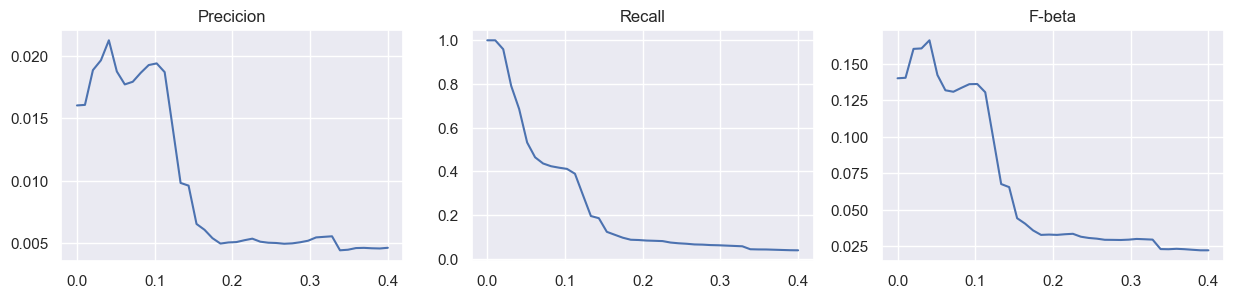

In [95]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.4)
)


In [108]:
get_badly_reconstructed_data_examples(
    autoencoder,
    test_data_full,
    test_data,
    test_labels,
    cls=1
)

,addrId,btc_received_total,incoming_tx_cnt,btc_sent_total,outcoming_tx_cnt,recon_err,user_addr_cnt
0,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,4.972163,23.0,4.571836,26.0,72.018944,14885
1,1DhSUSvEwsvHPALZQ8N6C4Ust68Le9NGX8,0.000000,0.0,0.010054,1.0,1.803914,14885
10,1FDu4itifPNG2FaHgfB2VvqLyV8zobLrvb,0.010351,1.0,1.053946,1.0,0.673571,236
56,1NBS7HWobQ5Voxdn5KKBBub2MH8tcvRHPs,0.004383,1.0,1.053946,1.0,0.209298,236
135,1KafqPHJHg4sZqW4kuKTcia4KwHPF9bb5P,0.008770,2.0,1.053946,1.0,0.395374,236
154,1Nv2TCN3xdeTquo1Q94shYjA6tt55CdPth,0.049983,1.0,1.053946,1.0,0.282219,236
184,154pSstBWkPQY169nqrw5kbkT8LuiXzZDe,0.004394,1.0,1.053946,1.0,0.251234,236
232,188hbQ1pYXF11SLCYaH7DbstnfcyxCcXQX,0.009834,1.0,1.053946,1.0,0.642430,236
239,3NpMEooqCMxtrB3U8uXLCb7TLtuzBMisFt,0.120332,2.0,0.007525,1.0,0.434399,1
249,1E6oNaMo35aRXTSjP9B6zkJuw3Tw9wokfX,0.370953,1.0,1.507036,1.0,0.257941,309


In [109]:
get_badly_reconstructed_data_examples(
    autoencoder,
    test_data_full,
    test_data,
    test_labels,
    cls=2
)

,addrId,btc_received_total,incoming_tx_cnt,btc_sent_total,outcoming_tx_cnt,recon_err,user_addr_cnt
1,3CswTd6V8V2uv24P9yWHpPnFiLfN4CABgW,15.734749,7.0,1472.667095,3.0,26.396732,238
5,1AyVSLR8yt8BCZvx8syjYJESNFfWgNuUzM,0.000000,0.0,96.747372,2.0,2.734701,5656
7,153wcbzkZo3VmXad42b2gP6DfANEX7ur54,0.000000,0.0,96.747372,2.0,2.734701,5656
9,1FXNGLdU1c1uMghi9r7xNpYA1jygC2juPD,0.000000,0.0,5.162142,2.0,1.156711,5656
10,16jzkB5PTsN8pp7bMApwevPYmd8xzT5NrW,0.000000,0.0,110.391948,2.0,2.985342,5656
12,1N1F8hrhAtV46kPjvTLF66yA9CM7THVLRg,0.000000,0.0,96.747372,2.0,2.734701,5656
14,18a6WnV2qMM9hExA2RDRrUzaH3EqpLiWhG,0.000000,0.0,2.431722,2.0,1.786161,60
17,1FoXbDsvXgwVoFwkszaZjkuRRDADoWTygX,0.028254,4.0,750.234006,2.0,4.217999,1
20,1EZ9PzwpYYHGPDFTLzZKs49UxTjtMZRw3g,0.000000,0.0,1.207649,4.0,2.051086,1
21,13Lt2uBNPwzuP1iyUHsddS2hGpk21pzZkF,0.000000,0.0,0.005000,1.0,0.287478,1


In [106]:
test_data_full["user_addr_cnt"]

,addrId,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,incoming_tx_cnt,incoming_tx_input_address_cnt_mean,incoming_tx_output_address_cnt_mean,btc_received_gini,input_address_cnt,...,user_btc_received_median,user_interracted_output_address_cnt,user_interracted_input_address_cnt,user_overall_activity_coef,user_user_ts_fees_share_mean,user_user_ts_fees_share_min,user_user_ts_fees_share_max,user_whole_fee_5,exchange_flg,transacted_w_exchange_flg
0,1CDaGcM5SSmkExKz1DpYNPbmryUPvbyYiL,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,2.0,0.0,0.000000,0.351403,0.351403,0.351403,0.0,False,False
1,1DtwQsqdqPHrgUtAAGANbiRnhwv2xXm6Jb,0.120635,0.120635,0.120635,0.120635,1.0,1.0,2.0,0.000000,1.0,...,0.059474,2.0,1.0,0.000000,5.980505,5.980505,5.980505,0.0,False,False
2,12NaccU2hdbqii1upcgnuaGLEhsDpxshwK,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,1.0,0.0,0.000000,1.913698,1.913698,1.913698,1.0,False,False
3,1BGTyzQRj12rYy6aRmUQsZYoCw5sMbz6MU,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,1.0,0.0,0.000000,1.913698,1.913698,1.913698,1.0,False,False
4,1G5yHgUjmQQrusLr9Mb3YykBoFT3UW4dkz,252.658502,87.838849,164.819653,126.329251,2.0,1.5,941.0,0.152342,3.0,...,0.000000,8.0,3.0,0.012121,0.358046,0.351403,0.364689,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281029,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,16.877397,16.877397,16.877397,16.877397,1.0,1.0,2.0,0.000000,1.0,...,0.005785,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,False,False
281030,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,16.871536,16.871536,16.871536,16.871536,1.0,1.0,2.0,0.000000,1.0,...,0.012649,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,False,False
281031,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,0.319490,0.319490,0.319490,0.319490,1.0,31.0,2.0,0.000000,29.0,...,0.009000,0.0,29.0,0.000000,0.000000,0.000000,0.000000,0.0,False,False
281032,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,16.858818,16.858818,16.858818,16.858818,1.0,1.0,2.0,0.000000,1.0,...,0.010000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,False,False
